In [31]:
# Imports


import numpy as np
import numpy.random as rnd
from matplotlib import pyplot as plt
import tensorflow as tf
import scipy.signal as sig
from datetime import datetime
import csv

import pandas as pd
from pandas_datareader import data as pd_data

from keras.models import Sequential
from keras.layers import LSTM,Dense,Activation

In [2]:
# Functions definition


# Generate data
def data_generator():
    t = np.arange(0,2,0.0002)
    f = np.sin(2*np.pi*7*t)+1.6*np.sin(2*np.pi*9*t)+0.1*rnd.randn(t.shape[0])
    f = f/np.max(f)
    return f 


# Split up data into training data and labels
def make_training_data(input_fn,lookback,prediction_len,permute_data=True):
    assert len(input_fn)>1
    data = []
    labels = []
    for k in range(lookback,len(input_fn)-prediction_len+1):
        xin = input_fn[k-lookback:k]
        yout = input_fn[k:k+prediction_len]
        data.append(xin)
        labels.append(yout)
    data = np.array(data)
    labels = np.array(labels)
    if permute_data==True:
        idx = rnd.permutation(data.shape[0])
        data = data[idx,:]
        labels = labels[idx,:]
    return data,labels

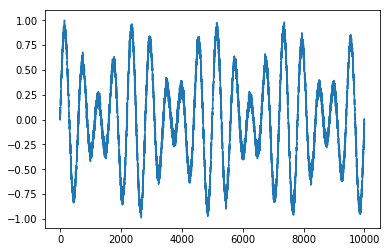

Data shape: (9991, 8)
Lable shape: (9991, 2)


In [16]:
# Make artificial data
f = data_generator()
plt.plot(f)
plt.show()


# Parameters
lookback = 8
pred_len = 2
state_size = 5


# Generate training and label sets
data,labels = make_training_data(f,lookback,pred_len)


# Print shape of resultig data
print('Data shape: '+str(data.shape))
print('Lable shape: '+str(labels.shape))

Training step 0/9991: 2.533741
Training step 1000/9991: 0.010224
Training step 2000/9991: 0.001443
Training step 3000/9991: 0.002496
Training step 4000/9991: 0.011681
Training step 5000/9991: 0.000447
Training step 6000/9991: 0.000107
Training step 7000/9991: 0.004340
Training step 8000/9991: 0.000322
Training step 9000/9991: 0.001508
INFO:tensorflow:Restoring parameters from STOCKSMODEL\rnn_simple_2018-09-01_13_11_02.ckpt


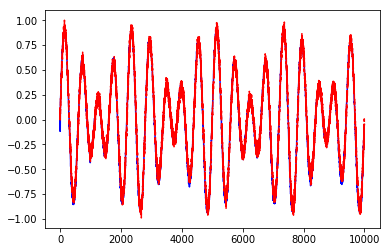

In [17]:
# SimpleRNN Solution


# Tensorflow RNN model
tf.reset_default_graph()

time_seq = tf.placeholder(shape=[lookback,1],dtype=tf.float32)
state_prev = tf.placeholder(shape=[state_size,1],dtype=tf.float32)
label = tf.placeholder(shape=[pred_len,1],dtype=tf.float32)

Whx = tf.Variable(tf.random_normal([state_size,lookback]))
Whh = tf.Variable(tf.random_normal([state_size,state_size]))
bh = tf.Variable(tf.random_normal([state_size,1]))

Wyh = tf.Variable(tf.random_normal([pred_len,state_size]))
by = tf.Variable(tf.random_normal([pred_len,1]))

next_state = tf.nn.sigmoid(tf.matmul(Whx,time_seq) + tf.matmul(Whh,state_prev) + bh)
prediction = tf.matmul(Wyh,next_state) + by

loss = tf.reduce_mean(tf.square(tf.subtract(prediction,label)))
opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)


# Training phase
c_ID = 'STOCKSMODEL\\rnn_simple_'+datetime.now().strftime("%Y-%m-%d_%H_%M_%S")+'.ckpt'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    state = np.zeros(shape=[state_size,1])
    
    for k in range(data.shape[0]):
        _,c_state,c_loss,mypred = sess.run([opt,next_state,loss,prediction],feed_dict={
            time_seq:np.reshape(data[k,:],[lookback,1]),
            state_prev:state,
            label:np.reshape(labels[k],[pred_len,1])
        })
        if k%1000==0:
            print('Training step %d/%d: %f'%(k,data.shape[0],c_loss))
        state = c_state
    
    saver = tf.train.Saver()
    saver.save(sess,c_ID)


# Test phase
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,c_ID)
    
    myseq = f[0:lookback]
    for k in range(lookback,data.shape[0]-pred_len,pred_len):
        mypred,c_state = sess.run([prediction,state_prev],feed_dict={
            time_seq:np.reshape(f[k:k+lookback],[lookback,1]),
            state_prev:state
        })
        myseq = np.append(myseq,-mypred)
        state = c_state

        
# Plot results
plt.plot(-myseq,'b')
plt.plot(f,'r--')
plt.show()


# Why is it still the negative?

In [ ]:
# Tensorflow Solution


# Tensorflow LSTM model
tf.reset_default_graph()

invec = tf.placeholder(shape=[None,lookback,1],dtype=tf.float32)
outvec = tf.placeholder(shape=[None,pred_len],dtype=tf.float32)
cell_state = tf.placeholder(shape=[None,state_size],dtype=tf.float32)
hidden_state = tf.placeholder(shape=[None,state_size],dtype=tf.float32)

init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state,hidden_state)
basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size,state_is_tuple=True)

rnn_out,next_state = tf.nn.dynamic_rnn(basic_cell,invec,initial_state=init_state,dtype=tf.float32)
rstage_out = tf.reshape(rnn_out, [-1,lookback])

prediction = tf.layers.dense(next_state.h,1)
loss = tf.reduce_mean(tf.square(prediction[0] - outvec))
train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)


# Training phase
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    this_cell_state = np.zeros([1,state_size])
    this_hidden_state = np.zeros([1,state_size])
    
    ctr = 0
    for (x,y) in zip(data,labels):
        
        _,myloss,mystate = sess.run([train,loss,next_state],feed_dict={
            invec:np.reshape(x,[1,lookback,1]),
            outvec:np.reshape(y,[1,pred_len]),
            cell_state:this_cell_state,
            hidden_state:this_hidden_state
        })
        myloss = np.array(myloss)
        np_state = np.array(mystate)
        
        this_cell_state = np.reshape(np_state[0,:,:],[1,state_size])
        this_hidden_state = np.reshape(np_state[1,:,:],[1,state_size])
        
        if ctr%1000==0: 
            print('Training step %d/%d: %f'%(ctr,data.shape[0],myloss))
        ctr+=1
        
    newpath = '.\\model_dir\\model'+datetime.now().strftime('%Y-%m-%d--%H-%M-%S')+'.ckpt'
    save_path = saver.save(sess,newpath)


# Test phase
with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess,newpath)
    
    this_cell_state = np.zeros([1,state_size])
    this_hidden_state = np.zeros([1,state_size])
    
    predicted_signal = []
    for k in range(lookback,len(f)-pred_len,pred_len):
        
        myxin = np.reshape(np.array(f[k-lookback:k]),[1,lookback,1])
        cpred,cstate = sess.run([prediction,next_state],feed_dict={
            invec:myxin,
            cell_state:this_cell_state,
            hidden_state:this_hidden_state
        })
        np_state = np.array(cstate)
        
        this_cell_state = np.reshape(np_state[0,:,:],[1,state_size])
        this_hidden_state = np.reshape(np_state[1,:,:],[1,state_size])
        
        predicted_signal.append(cpred[0])
        
        
# Plot results
plt.plot(sig.resample(predicted_signal,f.shape[0]),'b')
plt.plot(f,'r--')
plt.show()


# Needs to resample to original data length! 

Train on 8991 samples, validate on 1000 samples
Epoch 1/3
8991/8991 [==============================] - 34s 4ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 2/3
8991/8991 [==============================] - 32s 4ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 3/3
8991/8991 [==============================] - 33s 4ms/step - loss: 0.0020 - val_loss: 0.0017


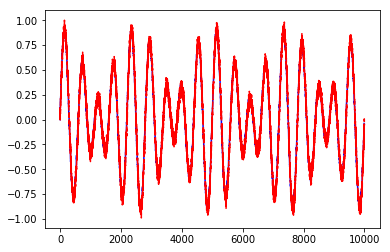

In [21]:
# Keras Solution


# Build model
model = Sequential()
model.add(LSTM(units=128,input_shape=(lookback,1)))
model.add(Dense(units=pred_len))
model.compile(loss='mse',optimizer='adam')


# Build training set
training_set_lstm = np.reshape(data,[data.shape[0],data.shape[1],1])
label_set_lstm = labels


# Training phase
model.fit(training_set_lstm,label_set_lstm,verbose=1,epochs=3,batch_size=5,validation_split=0.1)


# Test phase
myseq = f[0:lookback]
for k in range(lookback,data.shape[0]-pred_len,pred_len):
    mypred = model.predict(np.reshape(f[k:k+lookback],[1,lookback,1]))   
    myseq = np.append(myseq,mypred)

    
# Plot results
plt.plot(myseq,'b')
plt.plot(f,'r--')
plt.show()

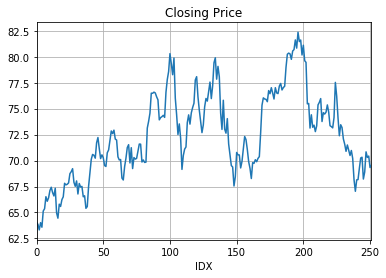

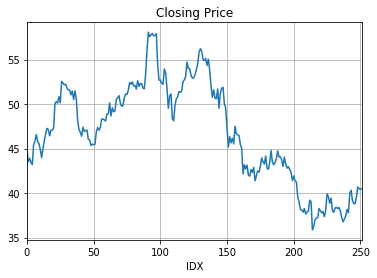

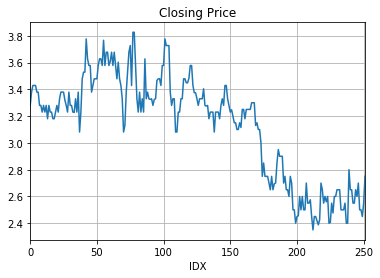

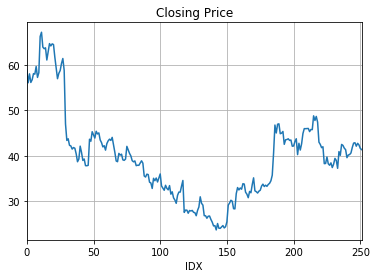

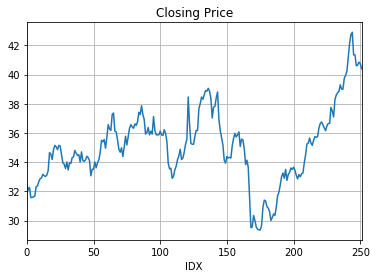

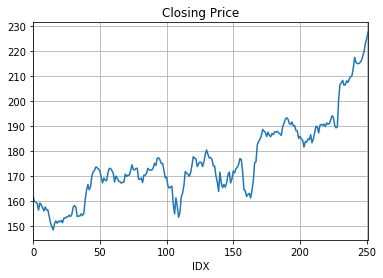

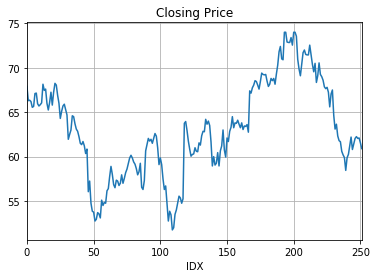

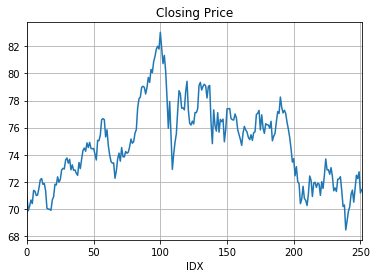

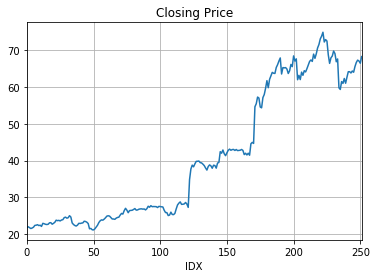

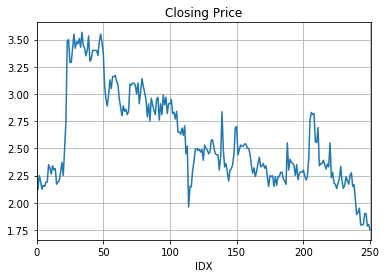

In [131]:
# Stocks data preparation


# Read in all available stock IDs from drive
with open('stock_symb.txt','r') as f:
    lines = f.readlines()
content = [line.strip() for line in lines]


# Select an ID
tickers = content[0:10]


# Set the time frame
start_date = datetime(2000,1,1)
end_date = datetime(2018,8,5)

DATA = []

# Read data as pandas frame
for ticker in tickers:
    
    try:
        panel_data = pd_data.DataReader(ticker,'robinhood',start_date,end_date,retry_count=0)
    except ValueError:
        print('Could not retrieve ticker') 


    # Restructure frame
    if not panel_data.index.name=='IDX':
        panel_data.insert(0,'IDX',range(252))
        panel_data = panel_data.set_index('IDX')
    panel_data['close_price'] = panel_data['close_price'].apply(lambda x: float(x))
    
    
    # Append to file
    DATA.append(panel_data)
    

# Plot some data
for d in DATA:
    plt.figure()
    d['close_price'].plot(grid=True,title='Closing Price')